## pycape worked example with simulation data from 21cmFAST

**Nick Kern**
<br>
**July, 2017**

---

Here we will create interpolation functions (an emulator) for the spherically-averaged 21cm brightness temperature power spectrum $P_{21}(k,z)$. The data itself are actually in the units $\Delta^{2}_{21}(k,z) = P_{21}(k,z)k^{3}/(2\pi^{2})\ [\rm{mK}^{2}]$. The data in `lh_training.pkl` are drawn from a random Latin-Hypercube design in a **three dimensional** model parameter space of the UV ionizing efficiency parameter ($\zeta$), the virial temperature of star-forming halos ($T_{vir}^{min}$), and the mean-free path of ionizing photons through ionized regions ($R_{mfp}$). The data in `gauss_data.pkl` have identical parameterization, but the samples are drawn from a multi-dimensional gaussina. The data in `lhsfs_data.pkl` are drawn from a Latin-Hypercube design within a hypersphere, rather than a hypercube. See [Kern et al. 2017](https://arxiv.org/abs/1705.04688) for parameterization details. The data in `cross_inspection.pkl` are drawn from a uniform grid across each individual parameter while holding all others constant. 

After creating a valid emulator, we then use a mock observation to perform a parameter constraint forecast of a HERA331-like interferometer.

The example below has certain code dependencies. See [emupy](github.com/nkern/emupy) and [pycape](github.com/nkern/pycape) for dependency details and installation instructions. Note that emupy & pycape, and by extension this example, is only supported for Python 2.7.

In [356]:
# Import modules
%matplotlib inline
import numpy as np
import emupy
import pycape
import cPickle as pkl
import sklearn.gaussian_process as gp
import astropy.stats as astats
import matplotlib.pyplot as mp
from curve_interp import curve_interp
import operator
import corner

In [378]:
# Load some training data
with open('gauss_data.pkl','rb') as f:
    inp = pkl.Unpickler(f)
    dic = inp.load()
    data = dic['data']
    grid = dic['grid']
    
# Load cross-data
with open('cross_inspection.pkl','rb') as f:
    inp = pkl.Unpickler(f)
    dic = inp.load()
    data_cr = dic['data']
    grid_cr = dic['grid']
    # Sort the cross_inspection data and split into three individual data sets
    fid_grid = np.median(grid_cr, axis=0)
    sort1 = np.where((grid_cr.T[1]==fid_grid[1])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort2 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort3 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[1]==fid_grid[1]))[0]
    data_cr1, grid_cr1 = data_cr[sort1], grid_cr[sort1]
    data_cr2, grid_cr2 = data_cr[sort2], grid_cr[sort2]
    data_cr3, grid_cr3 = data_cr[sort3], grid_cr[sort3]
    
# Randomly select from data_tr and assign to cross-validation set data_cv
rng = np.random.RandomState(1)
rando = rng.choice(np.arange(len(data)), replace=False, size=250)
select = np.array(np.zeros(len(data)), dtype=bool)
select[rando] = True
data_tr = data[select]
grid_tr = grid[select]
data_cv = data[~select]
grid_cv = grid[~select]

`data_tr` is the array containing our training data y-values. It has shape `(200, 33)`, which corresponds to 200 individual samples within our 3-dimensional model space, each with 33 individual data elements of $\Delta^{2}_{21}$ that we want to emulate. The 33 elements of the data correspond to the power spectrum across 11 $k$ values found in `k_range` at redshifts $z = [8, 9, 10]$.

`grid_tr` is the array containing the training data x-values. It has shape `(200, 3)`, which corresponds to the 200 individual samples within our 3-dimensional model space, each with a unique vector position in the 3-d parameter space.

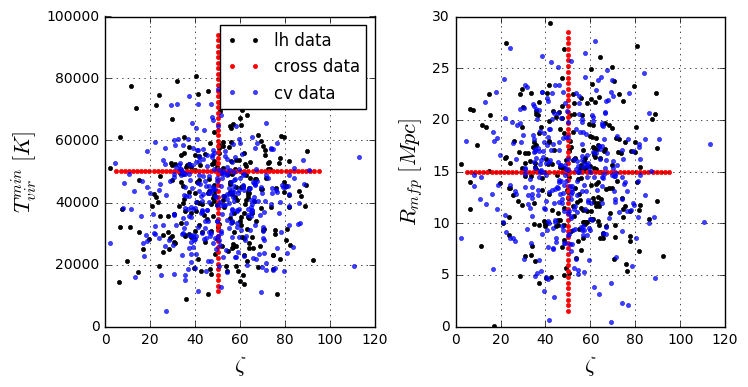

In [379]:
# Plot training data x-values
fig = mp.figure(figsize=(8,4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(121)
ax.grid(True)
p0, = ax.plot(grid_tr.T[0], grid_tr.T[1], 'k.')
p1, = ax.plot(grid_cr1.T[0], grid_cr1.T[1], 'r.')
ax.plot(grid_cr2.T[0], grid_cr2.T[1], 'r.')
p2, = ax.plot(grid_cv.T[0], grid_cv.T[1], 'b.', alpha=0.75)
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$T_{vir}^{min}\ [{K}]$', fontsize=16)
ax.legend([p0,p1,p2],['lh data', 'cross data', 'cv data'])

ax = fig.add_subplot(122)
ax.grid(True)
ax.plot(grid_tr.T[0], grid_tr.T[2], 'k.')
ax.plot(grid_cr1.T[0], grid_cr1.T[2], 'r.')
ax.plot(grid_cr3.T[0], grid_cr3.T[2], 'r.')
ax.plot(grid_cv.T[0], grid_cv.T[2], 'b.', alpha=0.75)
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$R_{mfp}\ [{Mpc}]$', fontsize=16)


### Set up emupy

In [380]:
# Initialize Emulator and its variables
# see help(E) for details on these parameters and their default values
E = emupy.Emu()

# Specify number of samples in training data
E.N_samples = len(data_tr)

# Specify number of model parameters
E.N_params = 3

# Specify number of data elements
E.N_data = len(data_tr.T)

# Specify usage of pca or not
E.use_pca = True

# specify covariance estimator
E.cov_est = astats.biweight_midcovariance

# If using pca, specify number of eigenmodes we want to keep during truncation
E.N_modes = 20

# Choose regression model for interpolation functions
E.reg_meth = 'gaussian'

# Choose to log normalize the data before taking covariance
E.lognorm = True

# Whiten the training data y-values
E.data_whiten = False

In [381]:
# Calculate fiducial (or average) data properties
E.fid_data = np.median(data_tr, axis=0)
E.fid_grid = np.median(grid_tr, axis=0)

### Set up pycape

In [382]:
# model parameters
params      = np.array(['zeta', 'Tvir', 'Rmfp'])
p_latex     = np.array([r'$\zeta$',r'$T_{vir}^{min}$',r'$R_{mfp}$'])
N_params    = len(params)

In [383]:
# Variables of model data
rest_freq       = 1.4204057517667   # GHz
zbin            = 0.5
z_array         = np.arange(8,10.1,zbin*2)
data_zlen       = len(z_array)
z_select        = np.arange(len(z_array))
k_range         = np.loadtxt('k_range.tab')
data_klen       = len(k_range)
k_select        = np.arange(len(k_range))
g_array         = np.array([])#r'nf',r'Tb'])
g_array_tex     = np.array([])#r'$\chi_{HI}$',r'$T_{b}$'])
g_select        = np.arange(len(g_array))

z_len   = len(z_select)
z_array = z_array[z_select]
k_len   = len(k_select)
k_range = k_range[k_select]
g_len   = len(g_select)            # for nf and aveTb

data_ylen = data_klen + g_len
y_len   = k_len + g_len
y_array = np.concatenate([k_range,g_array])
x_len = y_len * z_len

yz_data         = []
map(lambda x: yz_data.extend(map(list,zip(y_array,[x]*y_len))),z_array)
yz_data = np.array(yz_data)
yz_data = yz_data.reshape(z_len,y_len,2)

freq_low    = 1.4204057517667 / (z_array+zbin/2.0+1)
freq_high   = 1.4204057517667 / (z_array-zbin/2.0+1)
freq_cent   = np.round(1.4204057517667 / (z_array+1),8)
bandwidth   = np.round(1.4204057517667 / (z_array-zbin/2.0+1) - 1.4204057517667 / (z_array+zbin/2.0+1), 4)

param_width = np.array([grid_tr.T[i].max() - grid_tr.T[i].min() for i in range(N_params)])
eps = -0.001
param_bounds = np.array([[grid_tr.T[i].min()+param_width[i]*eps,grid_tr.T[i].max()-param_width[i]*eps]\
                            for i in range(N_params)])
param_hypervol = reduce(operator.mul,map(lambda x: x[1] - x[0], param_bounds))

In [384]:
# load mock observation and errors
file = open('mockObs_hera331.pkl','rb')
mock_data = pkl.Unpickler(file).load()
file.close()
p_true = mock_data['p_true']

In [385]:
# prep mock observation
prep_mock_data = mock_data.copy()
names = ['sense_kbins','sense_PSdata','sense_PSerrs']
for n in names:
    prep_mock_data[n] = np.array(prep_mock_data[n],object)
    for i in range(z_len):
        # Cut out inf and nans
        try: prep_mock_data[n][i] = prep_mock_data[n][i].T[prep_mock_data['valid'][i]].T.ravel()
        except: prep_mock_data[n]=list(prep_mock_data[n]);prep_mock_data[n][i]=prep_mock_data[n][i].T[prep_mock_data['valid'][i]].T.ravel()
        if n == 'sense_PSerrs':
            # Cut out sense_PSerrs / sense_PSdata > x% and high k-modes
            err_thresh = 1e3        # 1000%
            hi_k_cut = 2.0
            small_errs = np.where(prep_mock_data['sense_PSerrs'][i] / prep_mock_data['sense_PSdata'][i] < err_thresh)[0]
            hi_k = np.where(prep_mock_data['sense_kbins'][i][small_errs] < hi_k_cut)[0]
            prep_mock_data['sense_kbins'][i] = prep_mock_data['sense_kbins'][i][small_errs][hi_k]
            prep_mock_data['sense_PSdata'][i] = prep_mock_data['sense_PSdata'][i][small_errs][hi_k]
            prep_mock_data['sense_PSerrs'][i] = prep_mock_data['sense_PSerrs'][i][small_errs][hi_k]

prep_mock_data['sense_kbins'] = np.array( map(lambda x: np.array(x,float), prep_mock_data['sense_kbins']))

model_x     = prep_mock_data['kbins'][z_select]
obs_x       = prep_mock_data['sense_kbins'][z_select]
obs_y       = prep_mock_data['sense_PSdata'][z_select]
obs_y_errs  = prep_mock_data['sense_PSerrs'][z_select]
obs_track   = np.array(map(lambda x: ['ps' for i in range(len(x))], obs_x))
track_types = ['ps']

obs_y = np.concatenate(obs_y)
obs_y_errs = np.concatenate(obs_y_errs)
obs_x_nums = np.array([len(x) for x in obs_x])
obs_track = np.concatenate(obs_track.tolist())
track_types = np.array(track_types)

O = pycape.Obs(model_x,obs_x,obs_y,obs_y_errs,obs_track,track_types,p_true)

update_obs_dic = {'N_data':obs_y.size,'z_len':z_len,'z_array':z_array,
                'k_range':k_range,'obs_x_nums':obs_x_nums}
O.update(update_obs_dic)
E.yerrs = O.yerrs

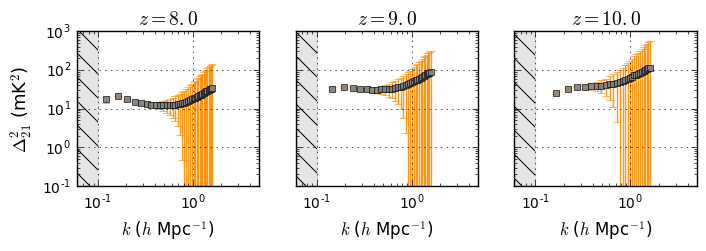

In [386]:
# plot mock obs
xdata = mock_data['sense_kbins']
ydata = mock_data['sense_PSdata']
yerrs = mock_data['sense_PSerrs']
valid = mock_data['valid']

fig = mp.figure(figsize=(8,2))
fig.subplots_adjust(hspace=0.02)

i = 0
for z in np.arange(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.grid(True)
    ax.errorbar(xdata[z][valid[z]], ydata[z][valid[z]], yerr=yerrs[z][valid[z]], color='grey', fmt='s', alpha=0.9, markersize=4, ecolor='darkorange')
    ax.axvspan(6e-2,1e-1, color='grey', alpha=0.2)
    ax.axvspan(6e-2,1e-1, hatch='\\', color='None', alpha=1.0)
    ax.set_xlim(6e-2, 5)
    ax.set_ylim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(r'$z = '+str(z_array[z])+'$', fontsize=14)
    ax.set_xlabel(r'$k$ ($h$ Mpc$^{-1}$)', fontsize=12)
    if i == 0:
        ax.set_ylabel(r'$\Delta^{2}_{21}$ (mK$^{2}$)', fontsize=13)
    else:
        ax.set_yticklabels([])

    i += 1


In [387]:
# interpolate model data k-values to observational k-values
def ps_interp(data, logps=True):
    # select out ps and other data
    ps_select = np.array([[True if i < data_klen else False for i in range(data_ylen)] for j in range(data_zlen)]).ravel()
    ps_data = np.array(map(lambda x: x[ps_select].reshape(data_zlen,data_klen), data))
    if logps == True:
        ps_data = np.log10(ps_data)
    other_data = data.T[~ps_select].T.reshape(len(data),data_zlen,g_len)
    ps_track = O.track(['ps'])
    # interpolate (or make prediction)
    ps_pred = np.array([curve_interp(ps_track[i],O.k_range,ps_data[:,i,:].T,n=2,degree=1) for i in range(z_len)])
    if logps == True:
        ps_pred = 10**(ps_pred)
    # reshape array
    data = [[] for i in range(len(ps_data))]
    for i in range(z_len):
        for j in range(len(ps_data)):
            try: data[j].extend(np.concatenate([ps_pred[i].T[j],other_data[j][i]]))
            except: data[j].extend(np.concatenate([np.array([]),other_data[j][i]]))
    return np.array(data)

data_tr     = ps_interp(data_tr)
data_cv     = ps_interp(data_cv)
data_cr     = ps_interp(data_cr)
data_cr1    = ps_interp(data_cr1)
data_cr2    = ps_interp(data_cr2)
data_cr3    = ps_interp(data_cr3)
E.fid_data  = ps_interp(E.fid_data[np.newaxis,:]).ravel()

In [388]:
# Make new yz_data matrix
yz_data = []
for i in range(z_len):
    kdat = np.array(np.around(O.xdata[i],3),str)
    zdat = np.array([z_array[i] for j in range(len(O.xdata[i]))],str)
    yz_data.append(np.array(zip(kdat,zdat)))
yz_data = np.array(yz_data)
yz_data_ext = O.row2mat(yz_data, row2mat=False)

In [389]:
# Sphere training data x values
E.sphere(grid_tr, fid_grid=E.fid_grid, save_chol=True, norotate=True)

In [390]:
# Perform KLT to calculate eigenmodes
E.klt(data_tr, fid_data=E.fid_data, normalize=True)

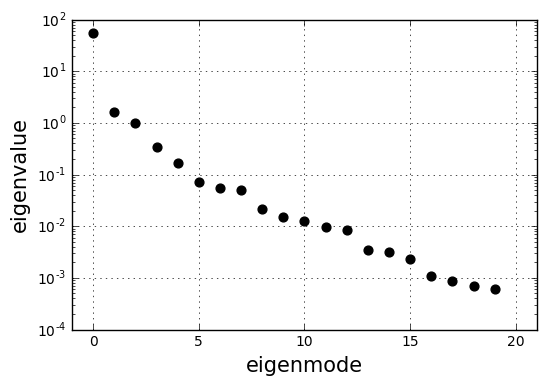

In [391]:
# plot eigenmodes if use_pca == True
if E.use_pca == True:
    fig = mp.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'eigenmode',fontsize=15)
    ax.set_ylabel(r'eigenvalue', fontsize=15)
    ax.grid(True)
    ax.set_xlim(-1,E.N_modes+1)
    ax.set_yscale('log')
    ax.scatter(np.arange(E.N_modes),E.eig_vals,color='k',s=40)

In [392]:
## Setup Gaussian Process kwargs
# Setup a squared exponential kernel with diagonal noise hyperparameter
kernel = gp.kernels.RBF(length_scale=np.ones(E.N_params)) + gp.kernels.WhiteKernel(noise_level=1e-6)

# How many times to restart MLE search of hyperparameters
n_restarts_optimizer = 10

# Which optimizer to use
optimizer='fmin_l_bfgs_b'

# pack into a dictionary
gp_kwargs = {'kernel':kernel, 'n_restarts_optimizer':n_restarts_optimizer, 'optimizer':optimizer}
E.gp_kwargs = gp_kwargs

In [393]:
# Train Emulator
E.train(data_tr, grid_tr, verbose=True)

...finished modegroup #0
...finished modegroup #1
...finished modegroup #2
...finished modegroup #3
...finished modegroup #4
...finished modegroup #5
...finished modegroup #6
...finished modegroup #7
...finished modegroup #8
...finished modegroup #9
...finished modegroup #10
...finished modegroup #11
...finished modegroup #12
...finished modegroup #13
...finished modegroup #14
...finished modegroup #15
...finished modegroup #16
...finished modegroup #17
...finished modegroup #18
...finished modegroup #19


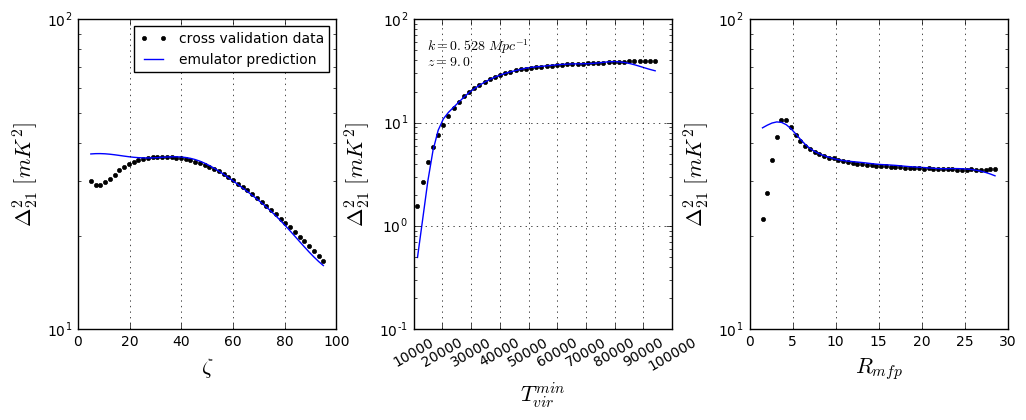

In [394]:
# Make predictions across cross_inspection data x-values
cr1_pred = E.predict(grid_cr1, output=True)
cr2_pred = E.predict(grid_cr2, output=True)
cr3_pred = E.predict(grid_cr3, output=True)

# Choose which data to look at i = [0, 33]
i = 45

# Initialize figure
fig = mp.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.3)

# Look across zeta
ax=fig.add_subplot(131)
ax.grid(True)
p0, = ax.plot(grid_cr1.T[0], data_cr1.T[i], 'k.')
p1, = ax.plot(grid_cr1.T[0], cr1_pred[0].T[i])
ax.set_yscale('log')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)
ax.legend([p0, p1], ['cross validation data', 'emulator prediction'], fontsize=10)

# Look across Tvir
ax=fig.add_subplot(132)
ax.grid(True)
ax.plot(grid_cr2.T[1], data_cr2.T[i], 'k.')
ax.plot(grid_cr2.T[1], cr2_pred[0].T[i])
[t.set_rotation(30) for t in ax.get_xticklabels()]
ax.set_yscale('log')
ax.set_xlabel('$T_{vir}^{min}$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)
ax.annotate("$k = %s\ Mpc^{-1}$" % yz_data_ext[i][0], (0.05,0.9), xycoords='axes fraction',fontsize=10)
ax.annotate("$z = %s$" % yz_data_ext[i][1], (0.05,0.85), xycoords='axes fraction',fontsize=10)

# Look across Rmfp
ax=fig.add_subplot(133)
ax.grid(True)
ax.plot(grid_cr3.T[2], data_cr3.T[i], 'k.')
ax.plot(grid_cr3.T[2], cr3_pred[0].T[i])
ax.set_yscale('log')
ax.set_xlabel('$R_{mfp}$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)

fractional error of 0.02 over random cv


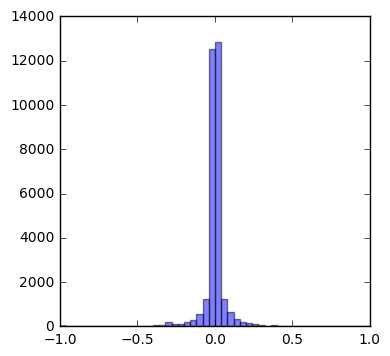

In [401]:
# random cross validatation
E.cross_validate(grid_cv, data_cv)
frac_err = np.log(E.recon_cv/data_cv)
err_std = np.sqrt(astats.biweight_midvariance(frac_err.ravel()))

fig = mp.figure(figsize=(4,4))
ax=fig.add_subplot(111)
p = ax.hist(frac_err.ravel(), bins=50, range=(-1,1), alpha=0.5)
print("fractional error of %.2f over random cv" % round(err_std,2))

In [396]:
# calibrate recon
recon = E.recon_cv
recon_err = E.recon_err_cv
weights = E.weights_cv
weights_err = E.weights_err_cv
weights_true = E.weights_true_cv

resid_loc = np.array(map(astats.biweight_location, recon.T/data_cv.T))**(-1)
E.recon_calib = resid_loc
recon *= E.recon_calib
resid_std = np.array(map(astats.biweight_midvariance, recon.T - data_cv.T))
avg_recon_err = np.array(map(astats.biweight_location, recon_err.T))
err_calib = resid_std / avg_recon_err
E.recon_err_calib = err_calib
recon_err *= E.recon_err_calib

X = recon.T-data_cv.T
Xsc = np.array(map(lambda x: astats.sigma_clip(x, sigma=3), X))
ps_err_cov = E.cov_est(X)
ps_sc_err_cov = E.cov_est(Xsc)

# add emulator error to covariance
O.cov += ps_err_cov

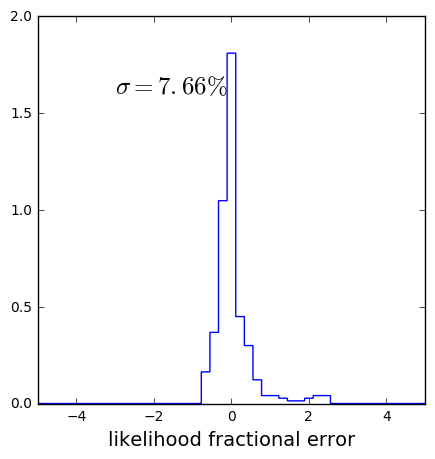

In [397]:
# cross validate likelihood
e_like, t_like = S.cross_validate(grid_cv,data_cv,lnlike_kwargs=lnprob_kwargs)

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)
frac_err = (e_like-t_like)/t_like
try: patches = ax.hist(frac_err,bins=45,histtype='step',range=(-5,5),normed=True,color='b')
except UnboundLocalError: pass
ax.set_xlim(-5,5)
ax.set_xlabel('likelihood fractional error',fontsize=14)
lnlike_sig = np.around(astats.biweight_midvariance(frac_err)*100,2)
ax.annotate(r'$\sigma = '+str(lnlike_sig)+'\%$',xy=(0.2,0.8),xycoords='axes fraction',fontsize=18)

In [398]:
###### set up sampler
use_Nmodes = None
add_model_cov = False
ndim = N_params
nwalkers = 20
vectorize_predict = True
fast = False

kwargs_tr = {}
predict_kwargs = {'fast':fast,'use_Nmodes':None,'kwargs_tr':kwargs_tr}

sampler_init_kwargs = {'use_Nmodes':use_Nmodes,'param_bounds':param_bounds,'param_hypervol':param_hypervol,
                            'nwalkers':nwalkers,'ndim':ndim,'N_params':ndim,'z_len':z_len}

lnprob_kwargs = {'add_model_cov':add_model_cov,'predict_kwargs':predict_kwargs,'vectorize':vectorize_predict}

In [399]:
# Initialize Ensemble Sampler
S = pycape.Samp(N_params, param_bounds, Emu=E, Obs=O)
sampler_kwargs = {'vectorize':True}
S.emcee_init(nwalkers, ndim, S.lnprob, lnprob_kwargs=lnprob_kwargs, sampler_kwargs=sampler_kwargs)
pos = np.copy(grid_cv[np.random.choice(np.arange(len(grid_cv)), replace=False, size=nwalkers)])

In [400]:
# run sampler
burn_num    = 0
step_num    = 250
S.samp_drive(pos, step_num=step_num, burn_num=burn_num)
chain = S.sampler.chain

In [402]:
# get samples 
samples = chain[:,50:,:].reshape((-1,chain.ndim))

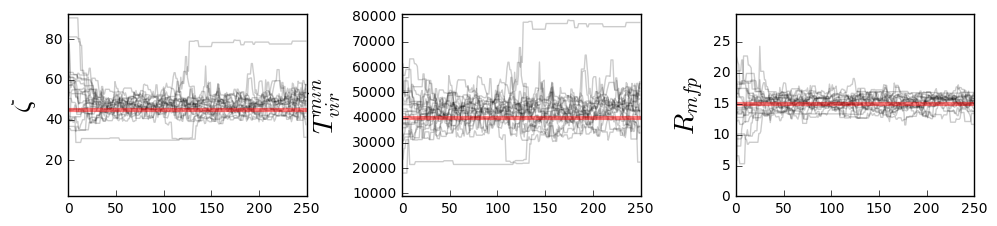

In [403]:
# Trace Plot 1
fig = mp.figure(figsize=(16,8))
fig.subplots_adjust(wspace=0.4,hspace=0.2)

for i in range(N_params):
    ax = fig.add_subplot(3,4,i+1)
    ax.set_ylabel(p_latex[i],fontsize=20)
    mp.tick_params(which='both',right='off',top='off')
    for j in range(len(chain)):
        ax.plot(chain[j,:,i],color='k',alpha=0.2)
        ax.set_ylim(param_bounds[i])
    ax.axhline(p_true[i],color='r',alpha=0.5,linewidth=3)

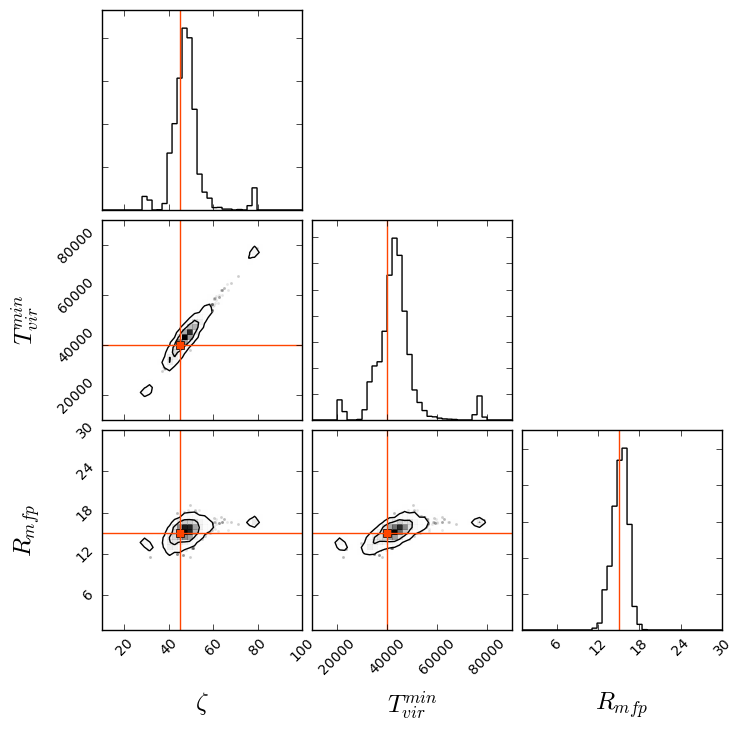

In [404]:
# plot tri-plot
levels = [0.68,0.95]
p_lims = [[10,100],[1e4,9e4],[1,30]]
label_kwargs = {'fontsize':18}

fig = corner.corner(samples, labels=p_latex, label_kwargs=label_kwargs, bins=40,
                                truths=p_true, range=p_lims, levels=levels, smooth=0.5, truth_color='orangered')
